# Predicting the average selling price in the oil gas sector

## 1) Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pycaret

## 2) Data loading

In [2]:
def load_data(path):
    '''
    This function returns the data set

    -----------
    Parameters
    -----------
    
    path : string
        Directory and name of the file

    -----------
    Returns
    -----------

    df : pandas dataframe
        Dataframe with the data
    '''
    
    df = pd.read_parquet(path)
    
    return df

In [3]:
df = load_data('data/oil_and_gas_dataset.parquet')
df.shape

(556501, 11)

## 3) Data pre-process

The first look at the data:

In [4]:
df.head()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,White Label,BA,Bahia,2917607,Jaguaquara,Gasolina,R$/litro,5,1.723251,2.030526,2004-05-01
1,Blue Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,33,1.225628,1.397636,2004-05-01
2,Green Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,128,1.224991,1.415282,2004-05-01
3,Green Label,SP,São Paulo,3505708,Barueri,Etanol,R$/litro,5,0.619567,0.856467,2004-05-01
4,White Label,SP,São Paulo,3513009,Cotia,Etanol,R$/litro,21,0.604228,0.804345,2004-05-01


In [11]:
df.tail()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
556496,Blue Label,MA,Maranhão,2111300,São Luís,Gasolina,R$/litro,4,NaN,5.836667,2024-08-01
556497,Blue Label,PA,Pará,1506807,Santarém,Diesel,R$/litro,6,NaN,6.234545,2024-08-01
556498,Purple Label,SP,São Paulo,3526902,Limeira,Diesel,R$/litro,4,NaN,6.006000,2024-08-01
556499,Purple Label,SP,São Paulo,3518800,Guarulhos,Diesel,R$/litro,1,NaN,6.040000,2024-08-01
556500,White Label,PB,Paraíba,2503209,Cabedelo,Etanol,R$/litro,4,NaN,4.753750,2024-08-01


In [8]:
df.describe()

,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
count,556501.000000,331360.000000,556501.000000,556501
mean,6.343187,2.278602,3.270554,2015-04-05 23:16:10.432758016
min,1.000000,0.413200,0.668744,2004-05-01 00:00:00
25%,2.000000,1.746553,2.205714,2010-07-01 00:00:00
50%,3.000000,2.190800,2.894286,2015-07-01 00:00:00
75%,6.000000,2.649900,3.967500,2020-03-01 00:00:00
max,1096.000000,4.747100,8.990000,2024-08-01 00:00:00
std,15.529743,0.713028,1.390611,NaN


In [9]:
nan_df = df.isna()

In [10]:
nan_df

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
556496,False,False,False,False,False,False,False,False,True,False,False
556497,False,False,False,False,False,False,False,False,True,False,False
556498,False,False,False,False,False,False,False,False,True,False,False
556499,False,False,False,False,False,False,False,False,True,False,False


Getting information about column names and types:

In [5]:
columns = df.columns.tolist()
columns

['bandeira_revenda_cat',
 'sigla_uf',
 'sigla_uf_nome',
 'id_municipio',
 'id_municipio_nome',
 'produto',
 'unidade_medida',
 'n_estabelecimentos',
 'avg_preco_compra',
 'avg_preco_venda',
 'data']

In [6]:
types = df.dtypes.to_dict()
types

{'bandeira_revenda_cat': dtype('O'),
 'sigla_uf': dtype('O'),
 'sigla_uf_nome': dtype('O'),
 'id_municipio': dtype('O'),
 'id_municipio_nome': dtype('O'),
 'produto': dtype('O'),
 'unidade_medida': dtype('O'),
 'n_estabelecimentos': dtype('int64'),
 'avg_preco_compra': dtype('float64'),
 'avg_preco_venda': dtype('float64'),
 'data': dtype('<M8[ns]')}

In [7]:
df.tail(30000)

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
526501,White Label,MA,Maranhão,2111201,São José de Ribamar,Etanol,R$/litro,11,NaN,4.063000,2023-11-01
526502,Blue Label,RO,Rondônia,1100189,Pimenta Bueno,Diesel,R$/litro,3,NaN,6.686667,2023-11-01
526503,White Label,TO,Tocantins,1721000,Palmas,Gasolina,R$/litro,25,NaN,5.813455,2023-11-01
526504,White Label,PB,Paraíba,2507507,João Pessoa,Diesel,R$/litro,2,NaN,5.770000,2023-11-01
526505,Purple Label,PB,Paraíba,2504009,Campina Grande,Gasolina,R$/litro,1,NaN,5.530000,2023-11-01
...,...,...,...,...,...,...,...,...,...,...,...
556496,Blue Label,MA,Maranhão,2111300,São Luís,Gasolina,R$/litro,4,NaN,5.836667,2024-08-01
556497,Blue Label,PA,Pará,1506807,Santarém,Diesel,R$/litro,6,NaN,6.234545,2024-08-01
556498,Purple Label,SP,São Paulo,3526902,Limeira,Diesel,R$/litro,4,NaN,6.006000,2024-08-01
556499,Purple Label,SP,São Paulo,3518800,Guarulhos,Diesel,R$/litro,1,NaN,6.040000,2024-08-01


Pre-processing the data:

In [7]:
def data_prep(df):
    '''
    This function is responsible for:
        1) Sample the data set
        2) Remove nan values
        3) Tranform categorical into numerical information 
        4) Removing columns with unique values
        5) Tranforming skewed and wide range variable distributions
        6) Sorting by data
        7) Removing "duplicate" information (similar variables)

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe with the whole data

    -----------
    Returns
    -----------

    df : pandas dataframe
        The modified dataframe
    '''

    #1) Sampling the data set
    df = df.sample(frac = 1)

    #2) Removing nan values
    df = df.dropna()

    #3) Transforming categorical to numerical information
    LE = LabelEncoder()
    for i in range(len(columns)):
        if types[columns[i]] == 'object':
            df[columns[i]] = LE.fit_transform(df[columns[i]])
        
    #4) Removing columns with unique values
    for i in range(len(columns)):
        if df[columns[i]].unique().shape[0] == 1:
            df = df.drop(columns[i], axis = 1)

    #5) Tranforming skewed and wide range variable distributions
    df['n_estabelecimentos'] = np.log10(df['n_estabelecimentos'])

    #6) Sorting by data
    df = df.sort_values(by = 'data')

    #7) Sorting by data
    df = df.drop('sigla_uf_nome', axis = 1)
    df = df.drop('id_municipio_nome', axis = 1)

    return df

In [8]:
df.shape

(556501, 11)

In [9]:
df = data_prep(df)
df.shape

(331360, 8)

Getting the new columns and types:

In [10]:
columns = df.columns.tolist()

In [11]:
types = df.dtypes.to_dict()

Taking a look at how the data looks like:

array([[<Axes: title={'center': 'bandeira_revenda_cat'}>,
        <Axes: title={'center': 'sigla_uf'}>,
        <Axes: title={'center': 'id_municipio'}>],
       [<Axes: title={'center': 'produto'}>,
        <Axes: title={'center': 'n_estabelecimentos'}>,
        <Axes: title={'center': 'avg_preco_compra'}>],
       [<Axes: title={'center': 'avg_preco_venda'}>,
        <Axes: title={'center': 'data'}>, <Axes: >]], dtype=object)

<Figure size 640x480 with 0 Axes>

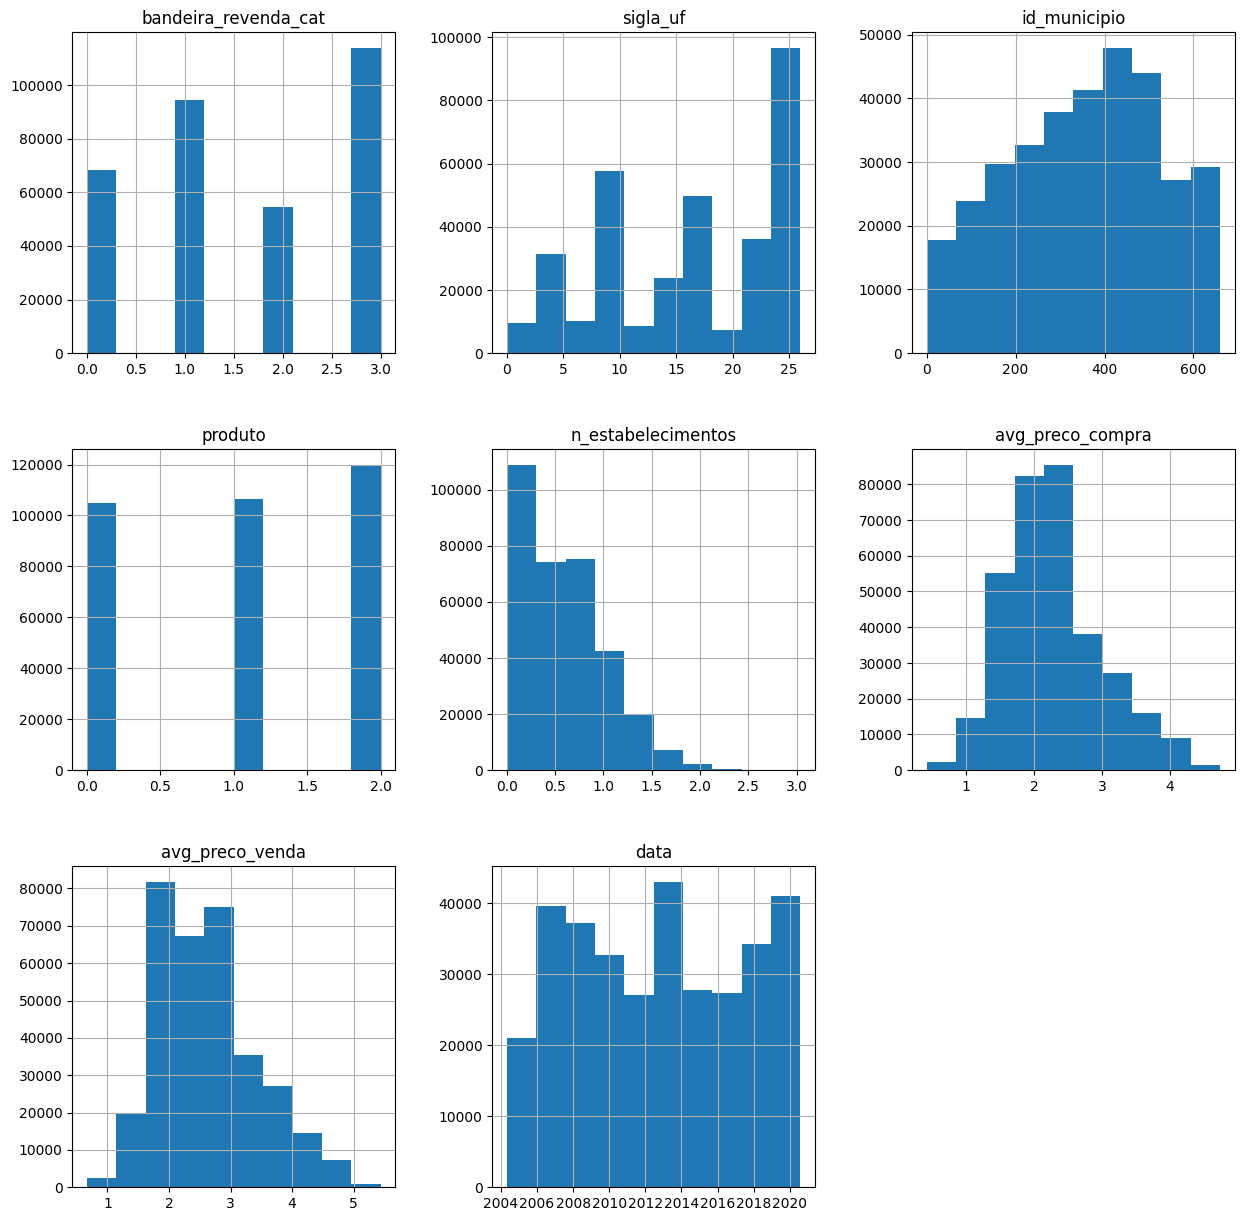

In [12]:
plt.figure(dpi = 100)
df.hist(bins = 10, figsize = (15, 15))

A bit about the statistics of the dataset:

In [13]:
df.describe()

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
count,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360.000000,331360
mean,1.647009,16.427282,353.915780,1.045591,0.616984,2.278602,2.632024,2012-08-08 15:37:37.518107136
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.413200,0.668744,2004-05-01 00:00:00
25%,1.000000,10.000000,220.000000,0.000000,0.301030,1.746553,1.997000,2008-05-01 00:00:00
50%,2.000000,17.000000,369.000000,1.000000,0.602060,2.190800,2.547333,2013-01-01 00:00:00
75%,3.000000,25.000000,482.000000,2.000000,0.903090,2.649900,3.075000,2017-03-01 00:00:00
max,3.000000,26.000000,660.000000,2.000000,3.039811,4.747100,5.438400,2020-08-01 00:00:00
std,1.152768,7.660722,170.255904,0.822397,0.438201,0.713028,0.800924,NaN


Getting data per product:

In [14]:
def data_per_product(df):
    '''
    This function is responsible for:
        1) Creating a dataframe per product
        2) Grouping the average price by data per product

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe with the whole data

    -----------
    Returns
    -----------

    df : pandas dataframe
        The modified dataframe
    '''

    #1) Creating a dataframe per product
    df_0 = df[df['produto'] == 0]
    df_1 = df[df['produto'] == 1]
    df_2 = df[df['produto'] == 2]

    #2) Grouping the average price by data per product
    new_df_0 = df_0.groupby('data')['avg_preco_venda'].mean().reset_index()
    new_df_1 = df_1.groupby('data')['avg_preco_venda'].mean().reset_index()
    new_df_2 = df_2.groupby('data')['avg_preco_venda'].mean().reset_index()

    #3) Creating new variables
    # Average preco de compra
    new_df_0['avg_preco_compra'] = df_0.groupby(['data'])['avg_preco_compra'].mean().reset_index()['avg_preco_compra']
    new_df_1['avg_preco_compra'] = df_1.groupby(['data'])['avg_preco_compra'].mean().reset_index()['avg_preco_compra']
    new_df_2['avg_preco_compra'] = df_2.groupby(['data'])['avg_preco_compra'].mean().reset_index()['avg_preco_compra']
    # Monthly price volatility - to sell
    new_df_0['volatility_preco_de_venda'] = df_0.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    new_df_1['volatility_preco_de_venda'] = df_1.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    new_df_2['volatility_preco_de_venda'] = df_2.groupby(['data'])['avg_preco_venda'].std().reset_index()['avg_preco_venda']
    # Monthly price volatility - to buy
    new_df_0['volatility_preco_de_compra'] = df_0.groupby(['data'])['avg_preco_compra'].std().reset_index()['avg_preco_compra']
    new_df_1['volatility_preco_de_compra'] = df_1.groupby(['data'])['avg_preco_compra'].std().reset_index()['avg_preco_compra']
    new_df_2['volatility_preco_de_compra'] = df_2.groupby(['data'])['avg_preco_compra'].std().reset_index()['avg_preco_compra']
    # Number of establishments
    new_df_0['avg_n_estabelecimentos'] = df_0.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    new_df_1['avg_n_estabelecimentos'] = df_1.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    new_df_2['avg_n_estabelecimentos'] = df_2.groupby(['data'])['n_estabelecimentos'].mean().reset_index()['n_estabelecimentos']
    # ID municipio
    new_df_0['avg_ID_municipio'] = df_0.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    new_df_1['avg_ID_municipio'] = df_1.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    new_df_2['avg_ID_municipio'] = df_2.groupby(['data'])['id_municipio'].mean().reset_index()['id_municipio']
    # Sigla UF
    new_df_0['avg_sigla_uf'] = df_0.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    new_df_1['avg_sigla_uf'] = df_1.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    new_df_2['avg_sigla_uf'] = df_2.groupby(['data'])['sigla_uf'].mean().reset_index()['sigla_uf']
    # Bandeira Revenda
    new_df_0['avg_bandeira_revenda_cat'] = df_0.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']
    new_df_1['avg_bandeira_revenda_cat'] = df_1.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']
    new_df_2['avg_bandeira_revenda_cat'] = df_2.groupby(['data'])['bandeira_revenda_cat'].mean().reset_index()['bandeira_revenda_cat']

    return new_df_0, new_df_1, new_df_2

Naming the products as (0, 1, 2):

In [15]:
df_0, df_1, df_2 = data_per_product(df)
df_0.shape, df_1.shape, df_2.shape

((93, 9), (93, 9), (93, 9))

Taking a look at how the data looks like for product 0:

In [16]:
df_0.head()

,data,avg_preco_venda,avg_preco_compra,volatility_preco_de_venda,volatility_preco_de_compra,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
0,2004-05-01,1.392554,1.228671,0.076642,0.050648,0.579584,350.418127,16.217523,1.650151
1,2004-06-01,1.448085,1.266157,0.078116,0.051574,0.575369,349.931055,16.281775,1.644484
2,2004-07-01,1.499478,1.322518,0.079192,0.053451,0.585732,348.943862,16.254164,1.655151
3,2005-01-01,1.681600,1.493951,0.088223,0.062278,0.559504,289.820244,11.221640,1.650960
4,2005-07-01,1.699903,1.514969,0.086216,0.055035,0.583332,346.229375,16.078125,1.645625


Taking a look at the correlation per product:

In [17]:
def correlation_heatmap(df):
    '''
    This function measures the correlation between the variables

    -----------
    Parameters
    -----------
    
    df : pandas dataframe
        Contains the dataframe in question

    -----------
    Returns
    -----------

    correlations :  pandas dataframe
        Constain all the data attributes with its respective correlations
    '''
    
    correlations = df.corr(method = 'pearson')
    
    return correlations

In [18]:
correlation_0 = correlation_heatmap(df_0)
correlation_1 = correlation_heatmap(df_1)
correlation_2 = correlation_heatmap(df_2)

In [19]:
look_0 = correlation_0['avg_preco_venda'].drop(['avg_preco_venda'])
look_1 = correlation_1['avg_preco_venda'].drop(['avg_preco_venda'])
look_2 = correlation_2['avg_preco_venda'].drop(['avg_preco_venda'])

Text(0.5, 0, 'Correlation')

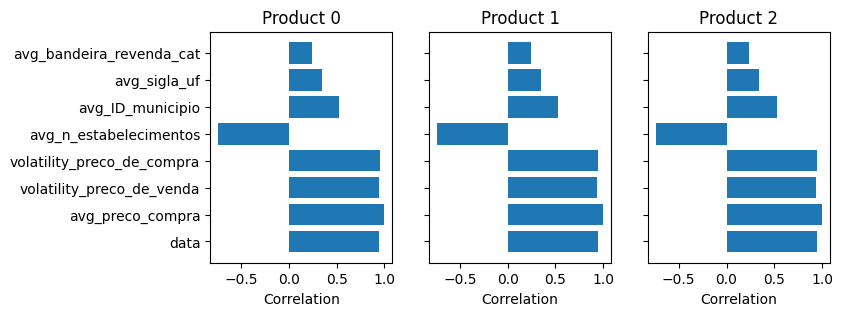

In [20]:
fig = plt.figure(dpi = 100, figsize = (8, 3))
gs = fig.add_gridspec(1, 3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].barh(look_0.index, look_0.values)
axs[0].set_title('Product 0')
axs[0].set_xlabel('Correlation')

axs[1].barh(look_1.index, look_0.values)
axs[1].set_title('Product 1')
axs[1].set_xlabel('Correlation')

axs[2].barh(look_2.index, look_0.values)
axs[2].set_title('Product 2')
axs[2].set_xlabel('Correlation')

We can see that the correlations are very similar to each other!

Getting the index to predict:

In [21]:
df_0.index = pd.to_datetime(df_0['data'], format='%Y-%m-%d')
df_1.index = pd.to_datetime(df_1['data'], format='%Y-%m-%d')
df_2.index = pd.to_datetime(df_2['data'], format='%Y-%m-%d')
del df_0['data']
del df_1['data']
del df_2['data']

In [22]:
df_0.head()

,avg_preco_venda,avg_preco_compra,volatility_preco_de_venda,volatility_preco_de_compra,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
data,,,,,,,,
2004-05-01,1.392554,1.228671,0.076642,0.050648,0.579584,350.418127,16.217523,1.650151
2004-06-01,1.448085,1.266157,0.078116,0.051574,0.575369,349.931055,16.281775,1.644484
2004-07-01,1.499478,1.322518,0.079192,0.053451,0.585732,348.943862,16.254164,1.655151
2005-01-01,1.681600,1.493951,0.088223,0.062278,0.559504,289.820244,11.221640,1.650960
2005-07-01,1.699903,1.514969,0.086216,0.055035,0.583332,346.229375,16.078125,1.645625


Taking a look at the average selling price per product:

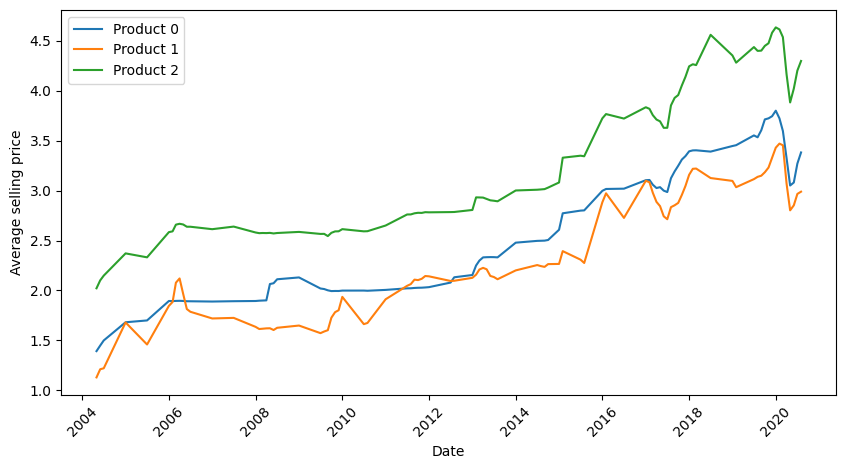

In [23]:
plt.figure(dpi = 100, figsize = (10, 5))
plt.ylabel('Average selling price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.plot(df_0.index, df_0['avg_preco_venda'], label = 'Product 0')
plt.plot(df_1.index, df_1['avg_preco_venda'], label = 'Product 1')
plt.plot(df_2.index, df_2['avg_preco_venda'], label = 'Product 2')
plt.legend()

Let's try to predict the price of product 0 using the correlation

First, we have to split the data into training and testing sets: "2019-09-01"

In [24]:
train_0 = df_0[df_0.index < pd.to_datetime("2019-09-01", format='%Y-%m-%d')]
test_0 = df_0[df_0.index > pd.to_datetime("2019-08-01", format='%Y-%m-%d')]

In [25]:
train_0.tail()

,avg_preco_venda,avg_preco_compra,volatility_preco_de_venda,volatility_preco_de_compra,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
data,,,,,,,,
2018-07-01,3.390795,3.036318,0.178994,0.140609,0.481042,365.699877,16.784748,1.685117
2019-01-01,3.446721,3.018801,0.211260,0.168275,0.546433,366.888517,16.701226,1.652174
2019-02-01,3.454991,3.068011,0.210687,0.159606,0.450675,361.037037,16.359788,1.719577
2019-07-01,3.553007,3.113476,0.191737,0.147598,0.513756,364.778652,16.652809,1.688764
2019-08-01,3.534181,3.108800,0.188642,0.142653,0.511263,365.056243,16.509561,1.664792


In [26]:
test_0.head()

,avg_preco_venda,avg_preco_compra,volatility_preco_de_venda,volatility_preco_de_compra,avg_n_estabelecimentos,avg_ID_municipio,avg_sigla_uf,avg_bandeira_revenda_cat
data,,,,,,,,
2019-09-01,3.604703,3.202132,0.190021,0.149923,0.517363,360.391608,16.454545,1.674825
2019-10-01,3.713234,3.338504,0.183738,0.139612,0.524091,361.219753,16.533333,1.679012
2019-11-01,3.723872,3.329198,0.186457,0.139584,0.512555,362.379001,16.704225,1.700384
2019-12-01,3.745267,3.360172,0.182604,0.143450,0.515552,357.806701,16.541237,1.695876
2020-01-01,3.800591,3.408489,0.179474,0.142334,0.538212,357.472938,16.353093,1.719072


In [27]:
train_0.shape, test_0.shape

((81, 8), (12, 8))

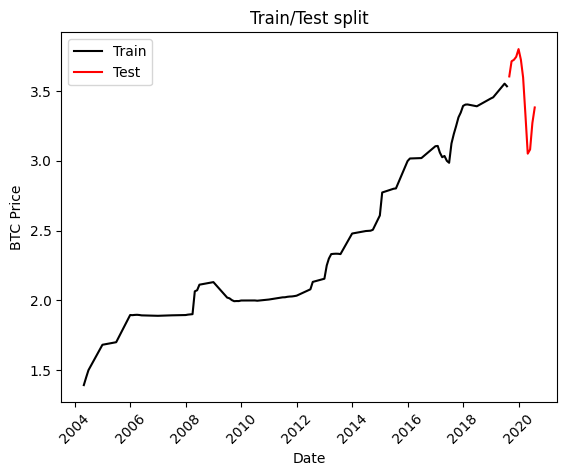

In [28]:
plt.figure(dpi = 100)
plt.plot(train_0['avg_preco_venda'], color = "black", label = 'Train')
plt.plot(test_0['avg_preco_venda'], color = "red", label = 'Test')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title("Train/Test split")
plt.legend()

In [29]:
y_train = train_0['avg_preco_venda']
exog_train = np.array([ train_0['avg_preco_compra'], train_0['volatility_preco_de_venda'], train_0['volatility_preco_de_compra'],
                        train_0['avg_n_estabelecimentos'], train_0['avg_ID_municipio'], train_0['avg_sigla_uf'], train_0['avg_bandeira_revenda_cat']
                      ]).T

y_train.shape, exog_train.shape

((81,), (81, 7))

In [30]:
y_test = test_0['avg_preco_venda']
exog_test = np.array([ test_0['avg_preco_compra'], test_0['volatility_preco_de_venda'], test_0['volatility_preco_de_compra'],
                        test_0['avg_n_estabelecimentos'], test_0['avg_ID_municipio'], test_0['avg_sigla_uf'], test_0['avg_bandeira_revenda_cat']
                      ]).T
y_test.shape, exog_test.shape

((12,), (12, 7))

In [31]:
ARIMAmodel = ARIMA(y_train, exog_train, order = (4, 2, 1))

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
ARIMAmodel = ARIMAmodel.fit()

In [33]:
y_pred_df_ARIMA = ARIMAmodel.predict(start = 81, end = 92, exog = exog_test)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


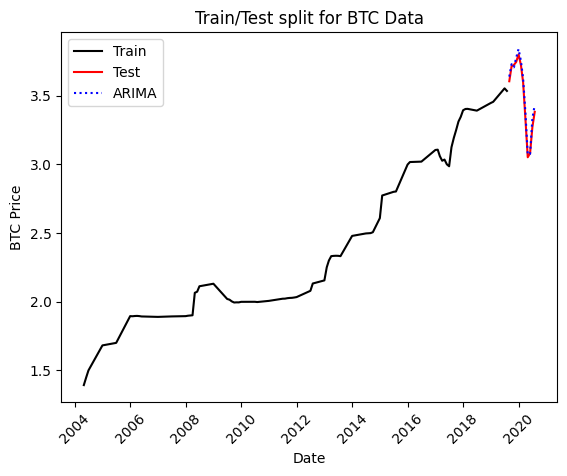

In [34]:
plt.figure(dpi = 100)
plt.plot(train_0["avg_preco_venda"], color = "black", label = 'Train')
plt.plot(test_0["avg_preco_venda"], color = "red", label = 'Test')
plt.plot(test_0.index, y_pred_df_ARIMA.values, color='Blue', ls = ':', label = 'ARIMA')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title("Train/Test split for BTC Data")
plt.legend()

Now, without exogenous variables:

In [35]:
#model = auto_arima(y_train, start_p=0, start_q=0, max_p=4, max_q=4, d=None, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-234.155, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-232.952, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-232.796, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-218.930, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-231.888, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.108 seconds


In [36]:
#model = auto_arima(y_train, seasonal=True, m = 12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-226.786, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-234.155, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-230.954, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-230.796, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-218.930, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-232.177, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-232.177, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-230.274, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-232.952, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-232.796, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-231.888, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.936 seconds


In [36]:
ARIMAmodel = ARIMA(y_train, order = (0, 1, 0))#(6, 3, 2))
ARIMAmodel = ARIMAmodel.fit()

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [37]:
y_pred_df_ARIMA = ARIMAmodel.predict(start = 81, end = 92)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


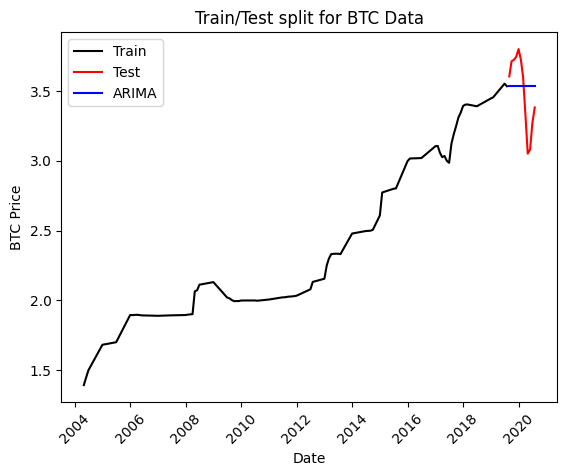

In [38]:
plt.figure(dpi = 100)
plt.plot(train_0["avg_preco_venda"], color = "black", label = 'Train')
plt.plot(test_0["avg_preco_venda"], color = "red", label = 'Test')
plt.plot(test_0.index, y_pred_df_ARIMA.values, color='Blue', label = 'ARIMA')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()

Doing predictions to the months asked:

In [39]:
date_range = pd.date_range('2019-09-01', '2024-08-01', freq = 'MS')
date_list = date_range.strftime('%Y-%m-%d').tolist()
len(date_list)

60

In [40]:
y_pred_df_ARIMA = ARIMAmodel.predict(start = 81, end = 92+48)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
preds = pd.DataFrame(data = y_pred_df_ARIMA.values)#, index = date_range)
preds.index = date_range
preds.shape

(60, 1)

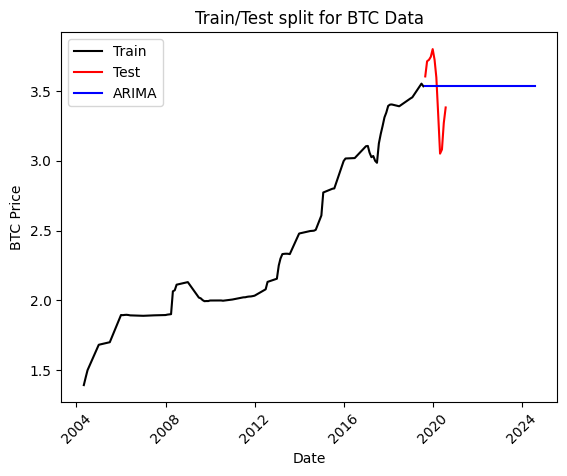

In [42]:
plt.figure(dpi = 100)
plt.plot(train_0["avg_preco_venda"], color = "black", label = 'Train')
plt.plot(test_0["avg_preco_venda"], color = "red", label = 'Test')
plt.plot(preds, color='Blue', label = 'ARIMA')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()